* reward function: with coefficient
* accuracy estimation: with predictor
* next item sampling: with random_choice
* input to lstm: tokens expanded
* data_x: without 0-steps

Tokens expanded
* lstm input shape: (6, 5)
* input to predict: (1, 6, 5)
* predicted output shape: (1, 382) return_sequences=False
* Uses one distribution to predict next layer token

In [1]:
import numpy as np
import keras
import random
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K
import scipy.stats as stats
import math
import tensorflow as tf
import itertools

In [2]:
# baseline = 0.85
loss_alpha = 0.9
rnn_lr = 0.01 
rnn_decay = 0.1
no_of_nas_epochs = 40
no_of_samples_per_epoch = 10
max_no_of_layers = 6
rnn_dim = 5
rnn_train_epochs = 16
search_space_len = 382
search_space = np.linspace(1,search_space_len,search_space_len)
rew_coef = 5

In [3]:
def plot_distribution(samples, prob, next_):
    fig, axs = plt.subplots(len(next_), figsize=(24, 6))
    for i in range(len(next_)):
        axs[i].axvline(x=next_[i], c="r", alpha=0.5)
        axs[i].plot(search_space, prob[i])
        axs[i].axis('off')    
    plt.show()

In [4]:
acc_model = keras.models.load_model("accuracy_predictor.h5")
def performance_estimate(sequence):
    seq_hot = keras.utils.to_categorical(sequence[:-1], num_classes=search_space_len+1)[np.newaxis]
    acc = acc_model.predict(seq_hot)[0][0]
    return round(acc, 3)

In [5]:
def discount_reward(rewards):
    discounted_reward = []
    for t in range(len(rewards)):
        dis_reward = 0
        for i, r in enumerate(rewards[t:]):
            dis_reward = loss_alpha**(i-t) * r
        discounted_reward.append(dis_reward)
    discounted_reward = tf.stack(discounted_reward)
    if len(rewards) > 1:
        discounted_reward = (discounted_reward - K.mean(discounted_reward)) / K.std(discounted_reward)
    return discounted_reward

In [6]:
def reinforce(y_true, y_pred):
    rewards = rew_coef * (data_acc - baseline)
    discounted_rewards = discount_reward(rewards)
    y_pred = K.clip(y_pred, 1e-36, 1e36)
    loss = - K.log(y_pred) * discounted_rewards[:, None]
    return loss

In [7]:
def expand_token(sequence):
    ranges = {
        "nodes": [4, 8, 12, 16, 20, 24, 28, 32, 36, 40],
        "layers": [1, 2],  # 1:"Conv2D", 2:"DepthwiseConv2D", 3:"Dense", 4:"dropout", 5:"softmax"
        "filters": [8, 16, 24, 32, 40],
        "paddings": [1, 2],  # 1:"valid", 2:"same"
        "activations": [1, 2],  # 1:"sigmoid", 2:"relu"
        "kernel_sizes": [1, 2, 3],  # 1:[1, 1], 2:[2, 2], 3:[3, 3]
        "strides": [1, 2, 3],  # 1:[1, 1], 2:[2, 2], 3:[3, 3]
        }
    cnn_params = list(itertools.product(*[ranges["layers"], ranges["filters"], ranges["kernel_sizes"], ranges["strides"], ranges["paddings"], 
                                          ranges["activations"]]))
    dense_params = list(itertools.product(*[[3], [0], [0], [0], ranges["nodes"], ranges["activations"]]))
    last_params = [[4, 2, 0, 0, 0, 0], [5, 2, 0, 0, 0, 0]]  # dropout 0.2, softmax 2
    dictionary = cnn_params + dense_params + last_params
    expanded = [dictionary[i-1] for i in sequence]
    return expanded

In [8]:
model = None
main_input = keras.engine.input_layer.Input(shape=(6, max_no_of_layers-1), batch_shape=None, name="main_input")
x = keras.layers.LSTM(rnn_dim, return_sequences=False)(main_input)
main_output = keras.layers.Dense(len(search_space), activation="softmax", name="main_output")(x)
model = keras.models.Model(inputs=[main_input], outputs=[main_output])

In [9]:
model.compile(loss={"main_output": reinforce}, optimizer=keras.optimizers.Adam(lr=rnn_lr, decay=rnn_decay, clipnorm=1.0))

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 6, 5)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5)                 220       
_________________________________________________________________
main_output (Dense)          (None, 382)               2292      
Total params: 2,512
Trainable params: 2,512
Non-trainable params: 0
_________________________________________________________________


In [11]:
# keras.utils.plot_model(model, "lstm.png", show_shapes=True)

NAS epoch 1
Epoch average accuracy (10 sequences): 0.571


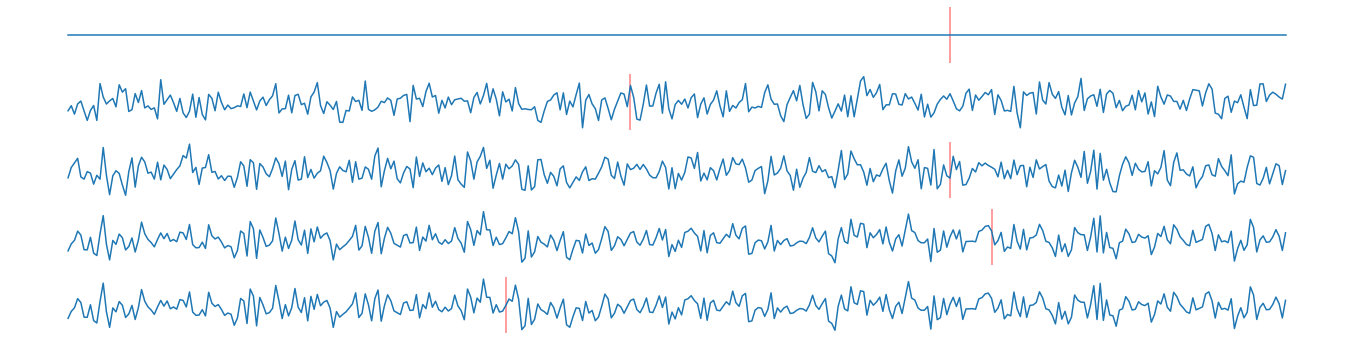

Training lstm ..
Rewards: [-0.525, -0.235, -0.52, -0.53, -0.42, 0.335, -0.525, -0.53, 0.975, -0.515]
lstm loss (epochs average): -6.646760546402675e-07
NAS epoch 2
Epoch average accuracy (10 sequences): 0.614


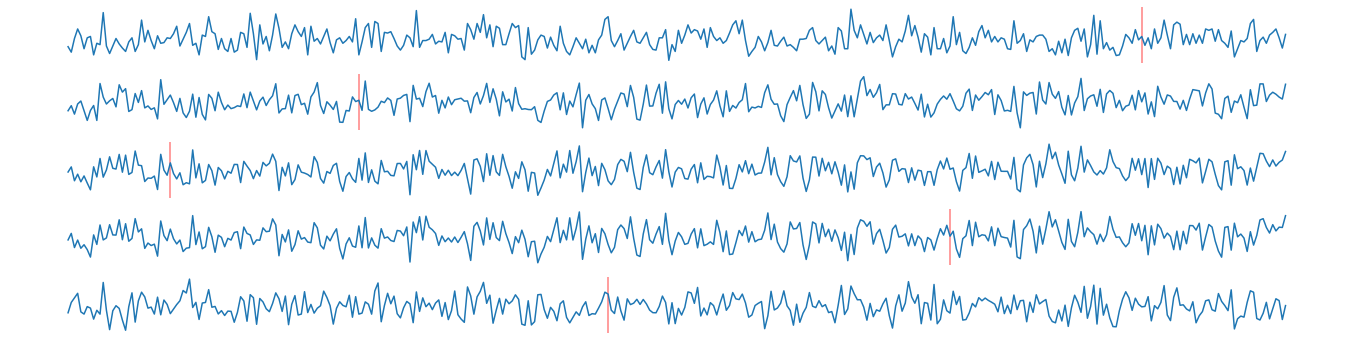

Training lstm ..
Rewards: [0.655, -0.67, -0.745, -0.005, -0.74, 0.66, -0.735, -0.715, -0.74, 0.55]
lstm loss (epochs average): -6.774582921309502e-07
NAS epoch 3
Epoch average accuracy (10 sequences): 0.664


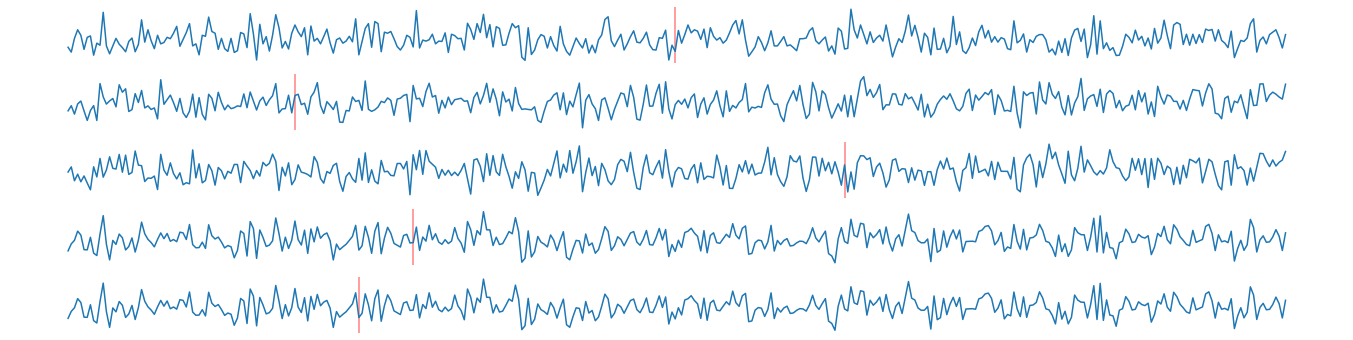

Training lstm ..
Rewards: [0.165, -0.925, -0.985, 0.28, -0.99, -0.185, 0.185, -0.935, 0.485, 0.43]
lstm loss (epochs average): -6.518938260313689e-07
NAS epoch 4
Epoch average accuracy (10 sequences): 0.62


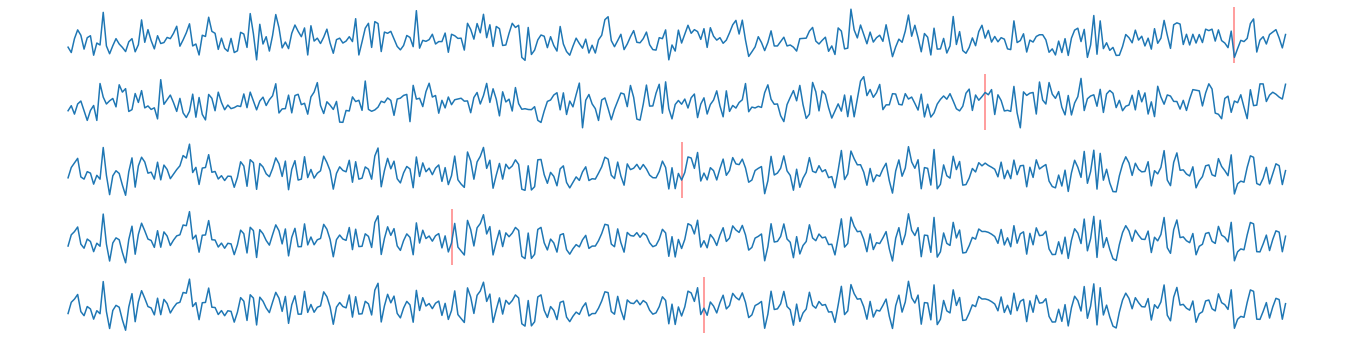

Training lstm ..
Rewards: [-0.77, -0.775, 0.345, -0.77, -0.295, -0.77, -0.77, 0.69, 0.135, 0.465]
lstm loss (epochs average): -7.66933915485879e-07
NAS epoch 5
Epoch average accuracy (10 sequences): 0.592


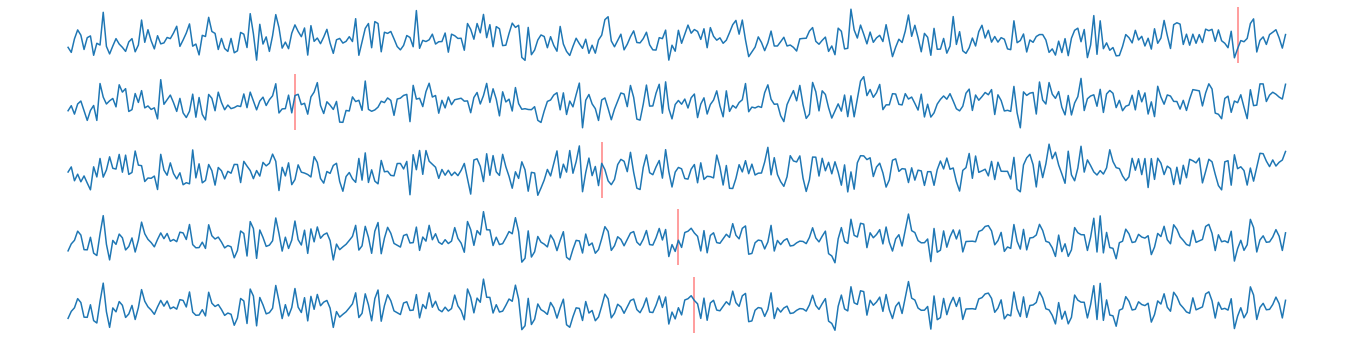

Training lstm ..
Rewards: [-0.6, 0.07, -0.635, -0.235, 0.215, 0.87, -0.615, -0.63, -0.325, -0.62]
lstm loss (epochs average): -6.646760546402675e-07
NAS epoch 6
Epoch average accuracy (10 sequences): 0.655


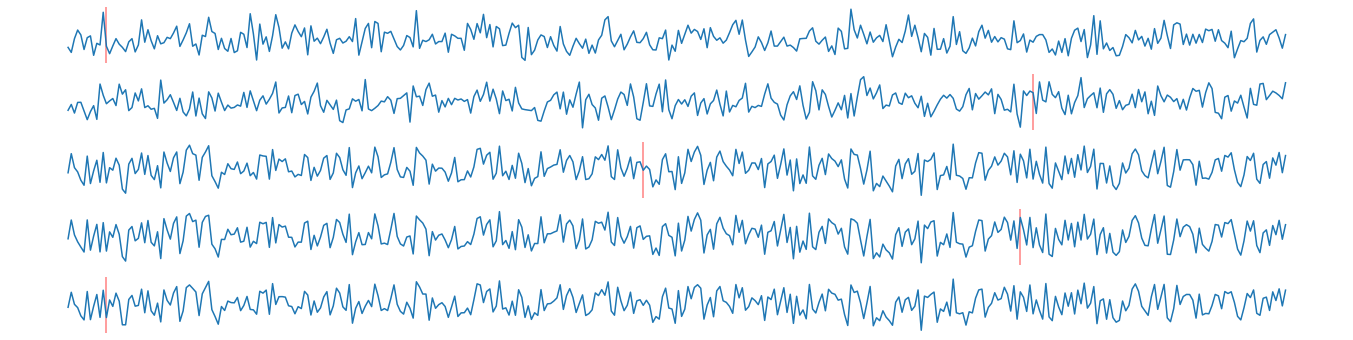

Training lstm ..
Rewards: [0.52, 0.35, 0.405, -0.95, -0.945, -0.92, 0.36, 0.325, -0.69, -0.945]
lstm loss (epochs average): -4.3459588461303156e-07
NAS epoch 7
Epoch average accuracy (10 sequences): 0.664


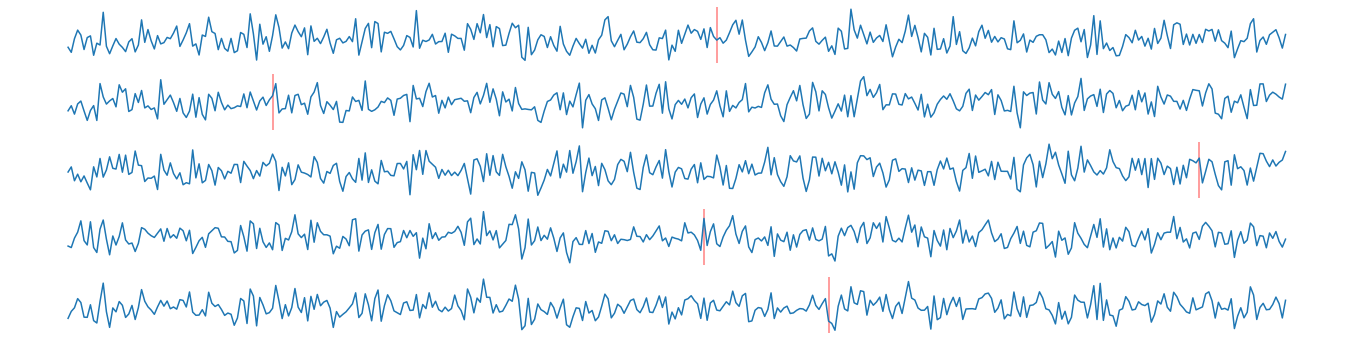

Training lstm ..
Rewards: [0.51, 0.295, 0.17, -0.995, -0.495, 0.51, 0.48, -0.99, -0.99, -0.98]
lstm loss (epochs average): -6.263293634845013e-07
NAS epoch 8
Epoch average accuracy (10 sequences): 0.689


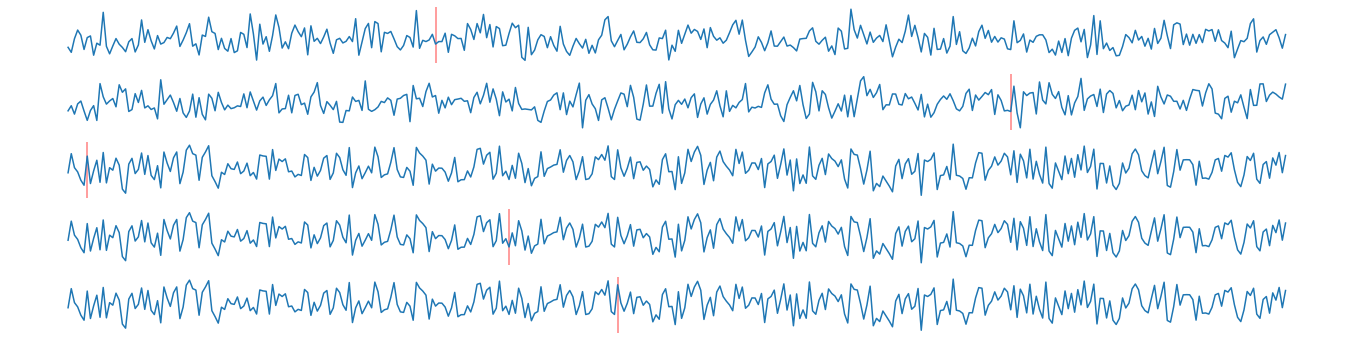

Training lstm ..
Rewards: [0.32, -1.07, 0.34, -1.06, -1.11, 0.535, -0.815, 0.245, 0.22, -0.1]
lstm loss (epochs average): -6.263293617081445e-07
NAS epoch 9
Epoch average accuracy (10 sequences): 0.632


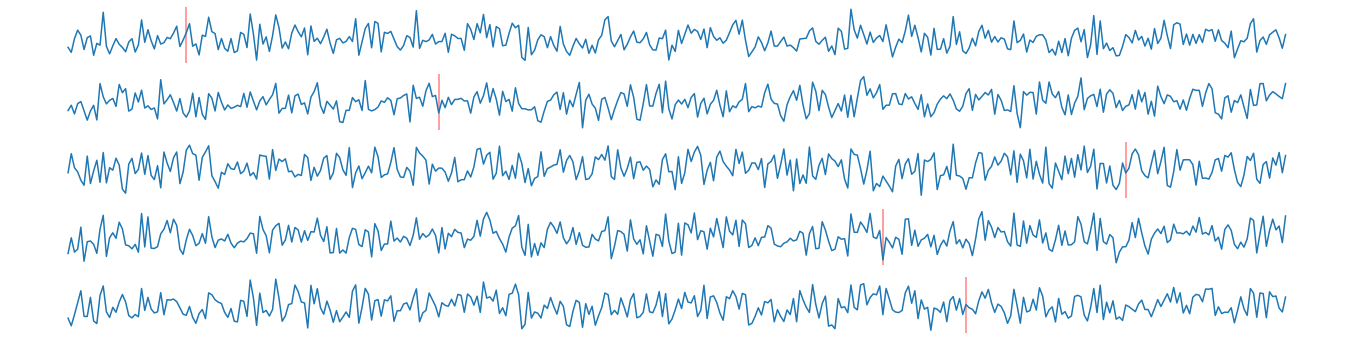

Training lstm ..
Rewards: [0.7, -0.83, -0.825, -0.795, 0.535, -0.835, -0.835, 0.59, -0.815, 0.61]
lstm loss (epochs average): -6.774582903545934e-07
NAS epoch 10
Epoch average accuracy (10 sequences): 0.676


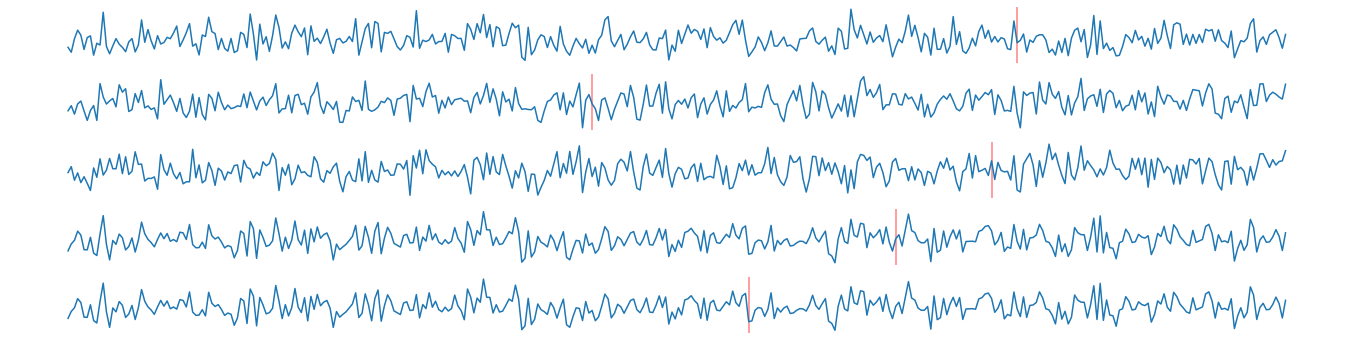

Training lstm ..
Rewards: [0.29, -1.05, 0.275, -1.05, 0.04, 0.365, 0.445, 0.23, -0.99, -1.05]
lstm loss (epochs average): -6.391115974224704e-07
NAS epoch 11
Epoch average accuracy (10 sequences): 0.557


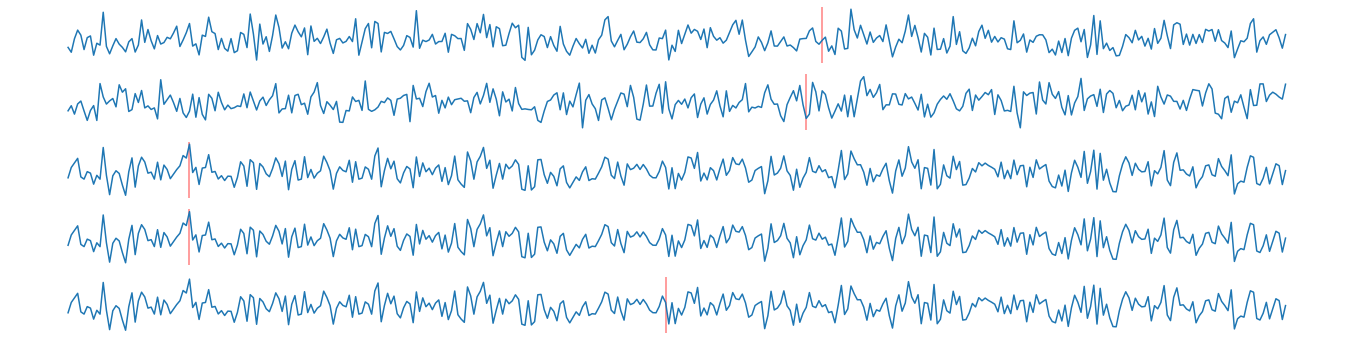

Training lstm ..
Rewards: [0.775, -0.23, -0.45, -0.33, -0.41, -0.455, -0.455, -0.015, -0.455, -0.455]
lstm loss (epochs average): -6.263293617081445e-07
NAS epoch 12
Epoch average accuracy (10 sequences): 0.628


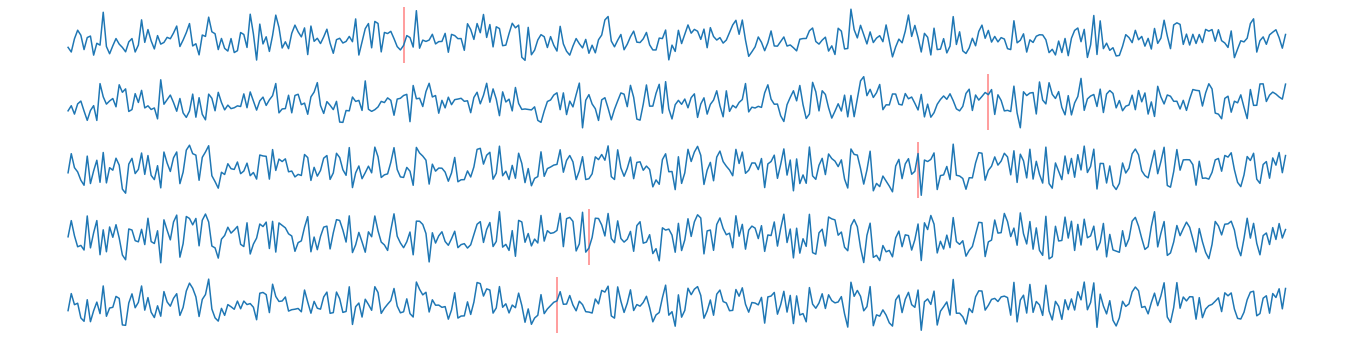

Training lstm ..
Rewards: [-0.805, 0.53, -0.81, -0.785, 0.6, 0.165, -0.81, -0.805, 0.165, 0.04]
lstm loss (epochs average): -7.158049903921437e-07
NAS epoch 13
Epoch average accuracy (10 sequences): 0.623


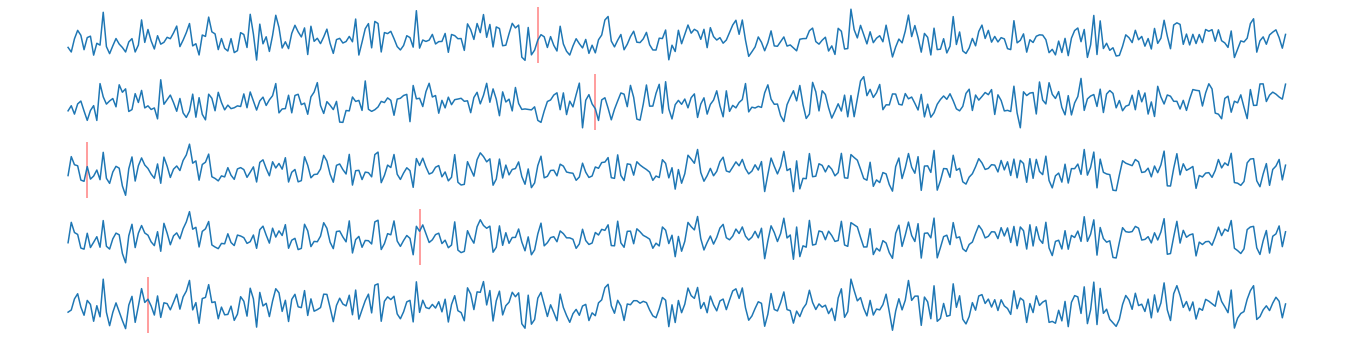

Training lstm ..
Rewards: [-0.785, -0.55, 0.135, -0.31, -0.785, -0.785, -0.74, 0.52, 0.405, 0.415]
lstm loss (epochs average): -6.007648956085632e-07
NAS epoch 14
Epoch average accuracy (10 sequences): 0.632


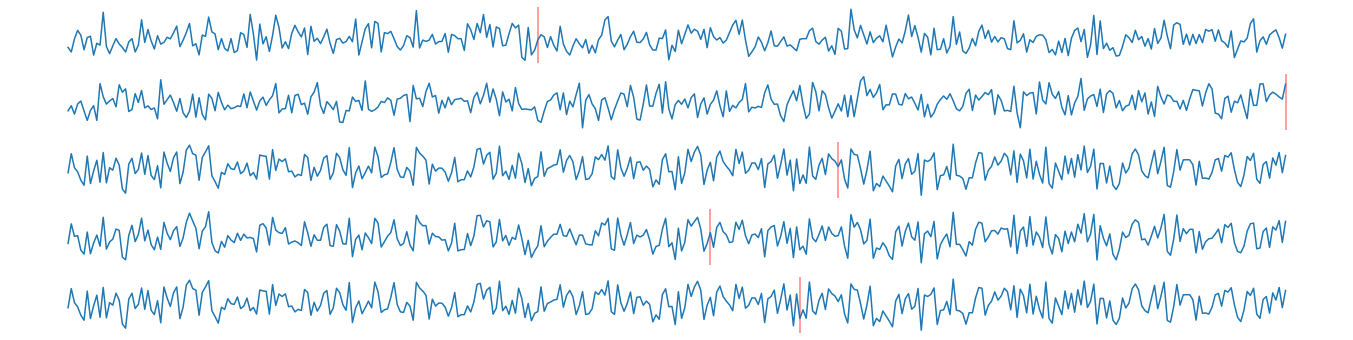

Training lstm ..
Rewards: [-0.83, -0.83, 0.415, -0.82, 0.29, -0.83, 0.475, -0.705, -0.06, 0.415]
lstm loss (epochs average): -6.518938278077258e-07
NAS epoch 15
Epoch average accuracy (10 sequences): 0.711


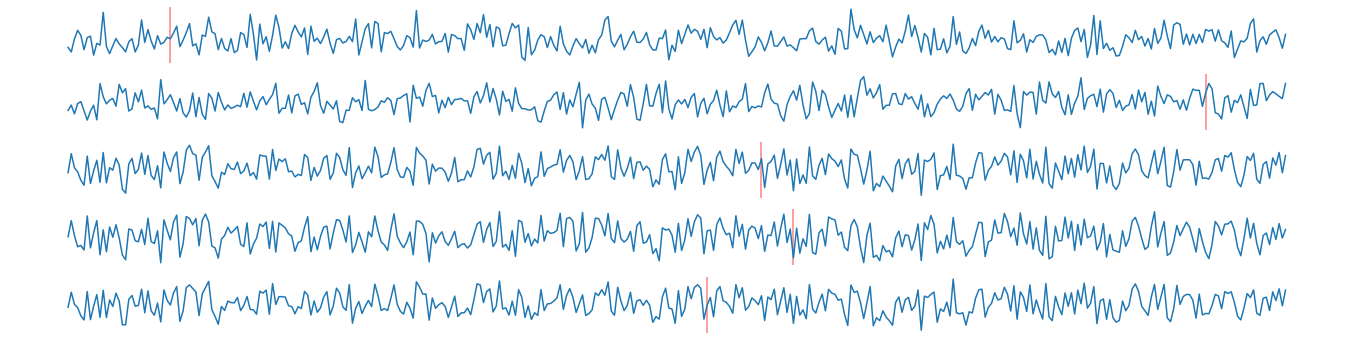

Training lstm ..
Rewards: [0.055, 0.055, 0.185, 0.225, 0.045, -1.14, 0.19, 0.345, -1.23, -1.225]
lstm loss (epochs average): -5.752004348380524e-07
NAS epoch 16
Epoch average accuracy (10 sequences): 0.751


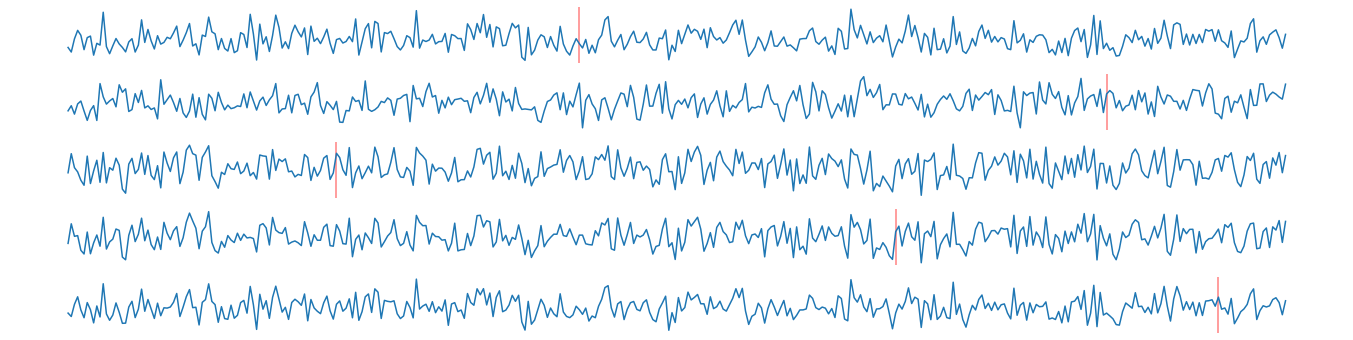

Training lstm ..
Rewards: [-0.755, -0.15, -0.705, -0.115, -0.16, -0.025, -0.62, -0.06, 0.07, -0.005]
lstm loss (epochs average): -6.902405260689193e-07
NAS epoch 17
Epoch average accuracy (10 sequences): 0.669


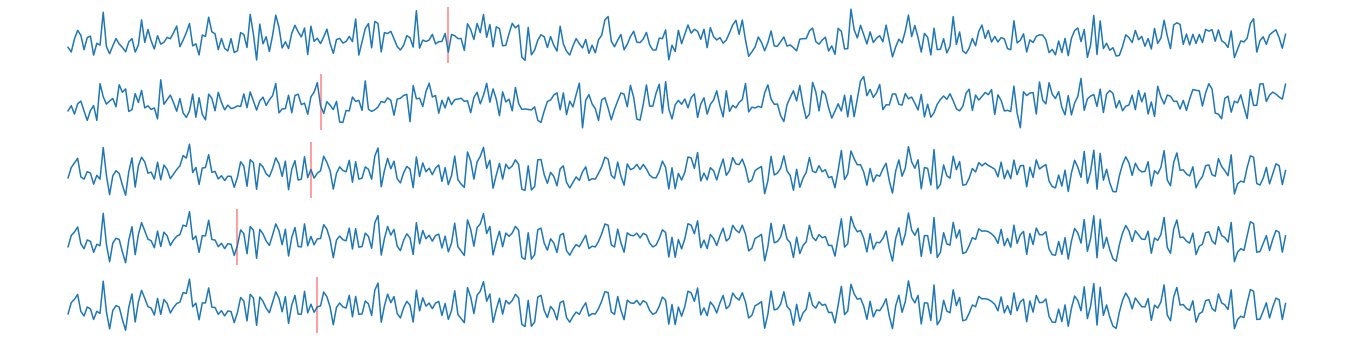

Training lstm ..
Rewards: [0.355, 0.37, 0.21, -1.015, 0.285, -1.015, -1.01, -0.08, -0.915, 0.305]
lstm loss (epochs average): -6.902405225162056e-07
NAS epoch 18
Epoch average accuracy (10 sequences): 0.654


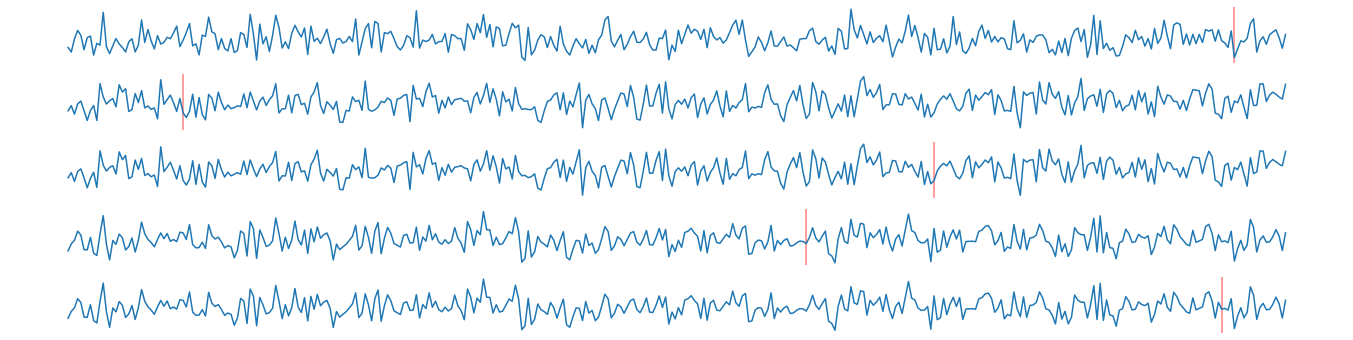

Training lstm ..
Rewards: [-0.94, -0.945, 0.44, -0.945, 0.43, 0.595, -0.945, 0.355, 0.205, -0.755]
lstm loss (epochs average): -6.774582885782365e-07
NAS epoch 19
Epoch average accuracy (10 sequences): 0.692


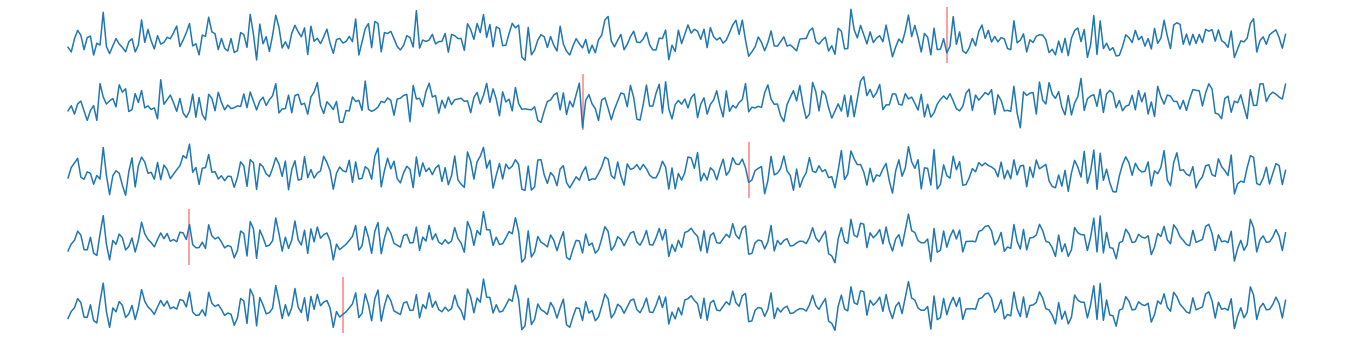

Training lstm ..
Rewards: [-1.13, 0.325, 0.185, -0.98, 0.06, 0.225, -0.525, 0.225, 0.23, -1.115]
lstm loss (epochs average): -7.413694547153682e-07
NAS epoch 20
Epoch average accuracy (10 sequences): 0.656


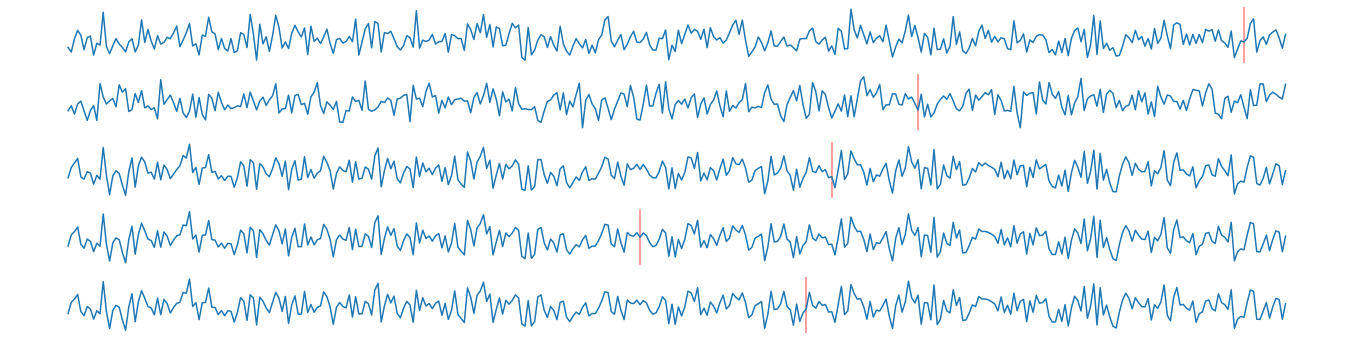

Training lstm ..
Rewards: [0.09, -0.84, 0.29, -0.425, -0.95, 0.24, -0.945, 0.44, -0.945, 0.525]
lstm loss (epochs average): -6.646760546402675e-07
NAS epoch 21
Epoch average accuracy (10 sequences): 0.656


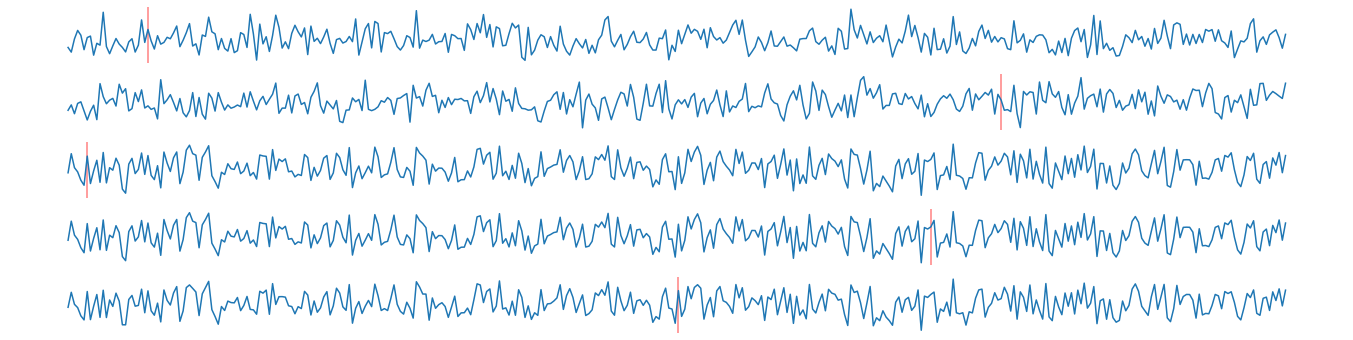

Training lstm ..
Rewards: [-0.955, 0.31, -0.95, 0.535, -0.95, 0.5, -0.79, -0.955, 0.415, 0.325]
lstm loss (epochs average): -7.669339119331653e-07
NAS epoch 22
Epoch average accuracy (10 sequences): 0.646


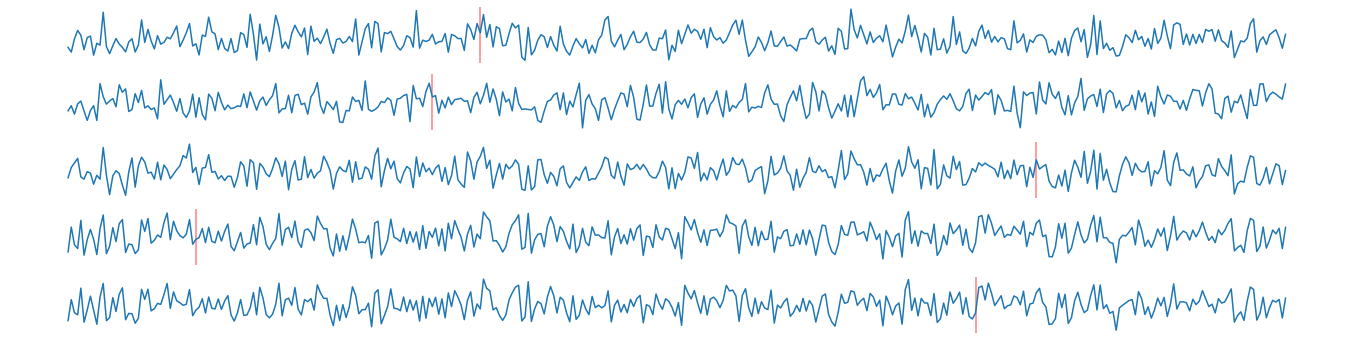

Training lstm ..
Rewards: [-0.77, -0.9, 0.52, -0.095, 0.345, 0.52, -0.9, 0.49, -0.82, -0.905]
lstm loss (epochs average): -5.879826723287351e-07
NAS epoch 23
Epoch average accuracy (10 sequences): 0.695


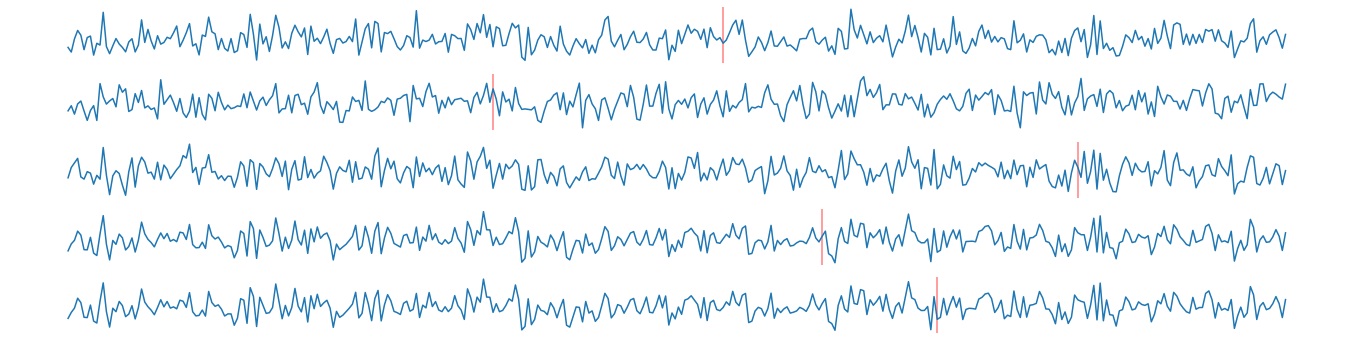

Training lstm ..
Rewards: [0.23, 0.245, 0.39, 0.17, -1.145, 0.335, -1.15, -1.05, -0.755, 0.24]
lstm loss (epochs average): -6.774582956836639e-07
NAS epoch 24
Epoch average accuracy (10 sequences): 0.681


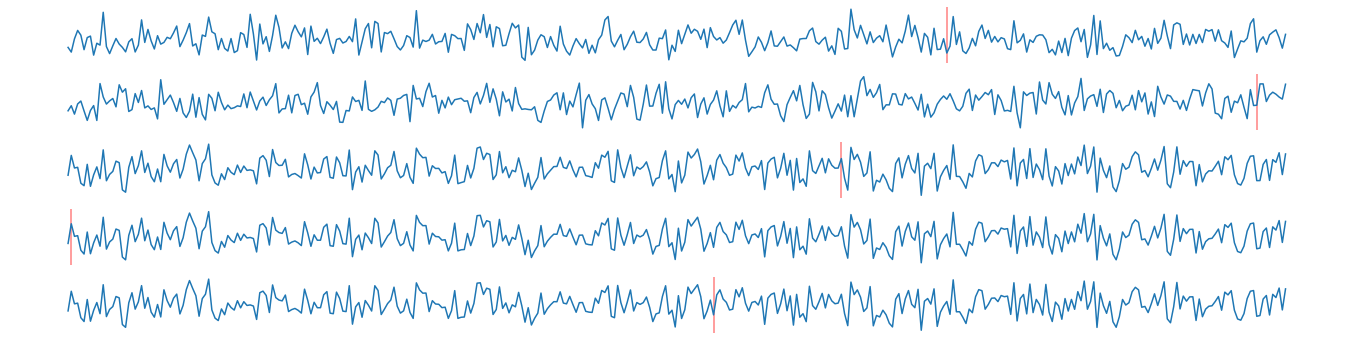

Training lstm ..
Rewards: [0.19, 0.295, 0.13, -1.07, -1.05, -0.175, -1.07, -0.18, 0.27, 0.15]
lstm loss (epochs average): -6.135471330992459e-07
NAS epoch 25
Epoch average accuracy (10 sequences): 0.643


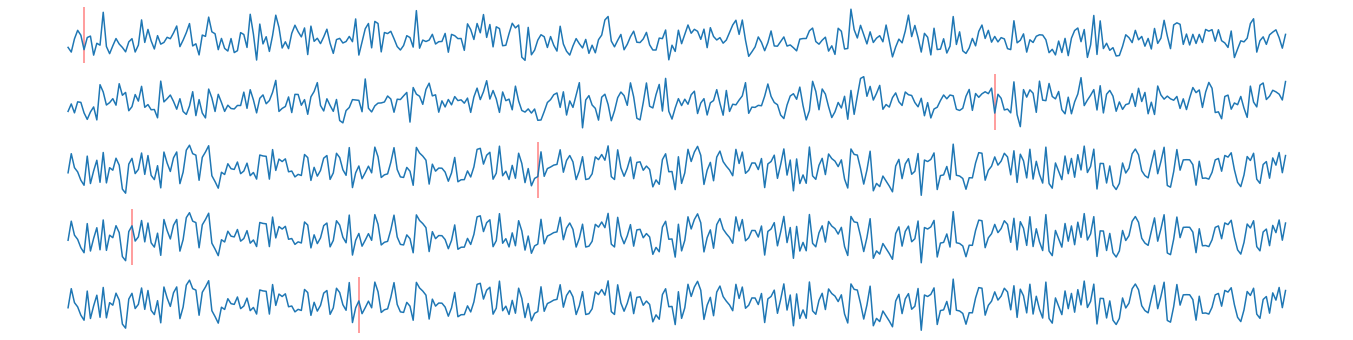

Training lstm ..
Rewards: [-0.89, 0.38, 0.415, 0.46, -0.885, -0.475, -0.88, -0.79, -0.31, 0.485]
lstm loss (epochs average): -6.774582921309502e-07
NAS epoch 26
Epoch average accuracy (10 sequences): 0.698


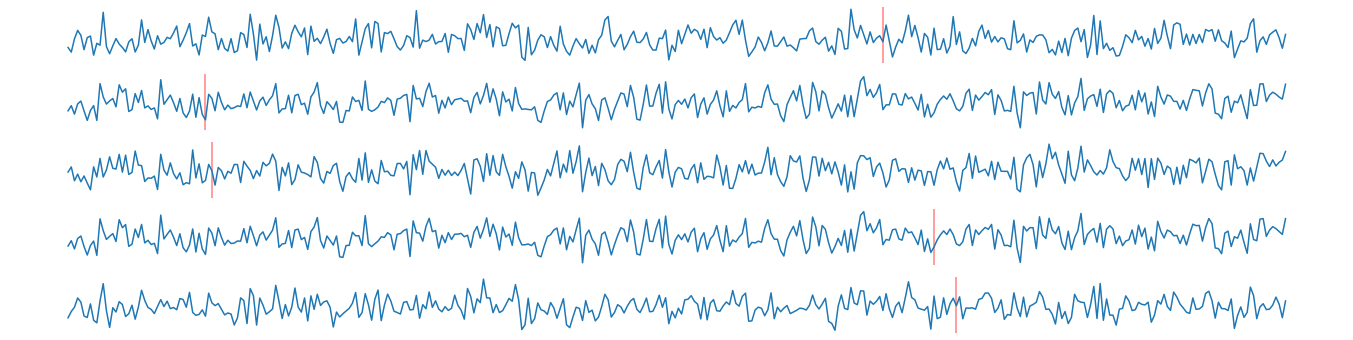

Training lstm ..
Rewards: [0.18, 0.13, -1.16, 0.16, -0.04, -1.165, -1.14, 0.295, 0.05, 0.185]
lstm loss (epochs average): -6.774582885782365e-07
NAS epoch 27
Epoch average accuracy (10 sequences): 0.655


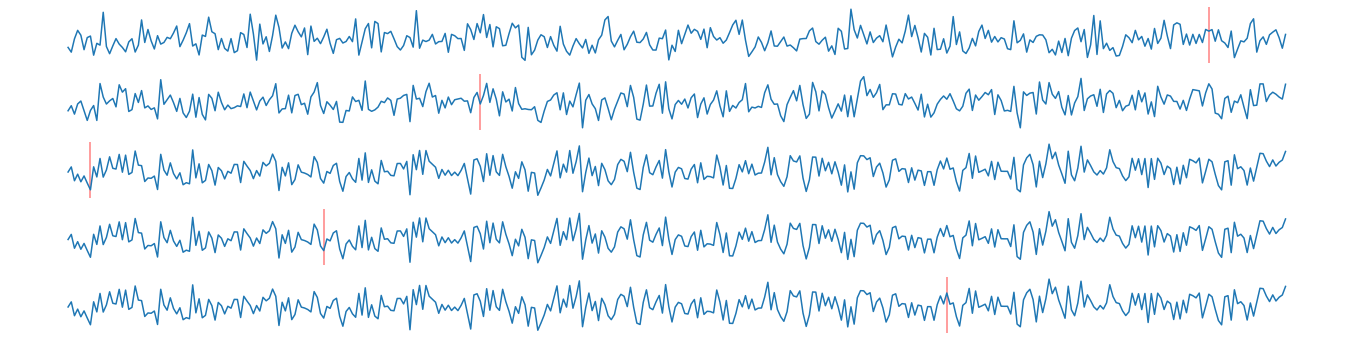

Training lstm ..
Rewards: [-0.89, -0.95, -0.945, 0.255, 0.51, 0.39, -0.94, -0.945, 0.445, 0.56]
lstm loss (epochs average): -6.391115974224704e-07
NAS epoch 28
Epoch average accuracy (10 sequences): 0.615


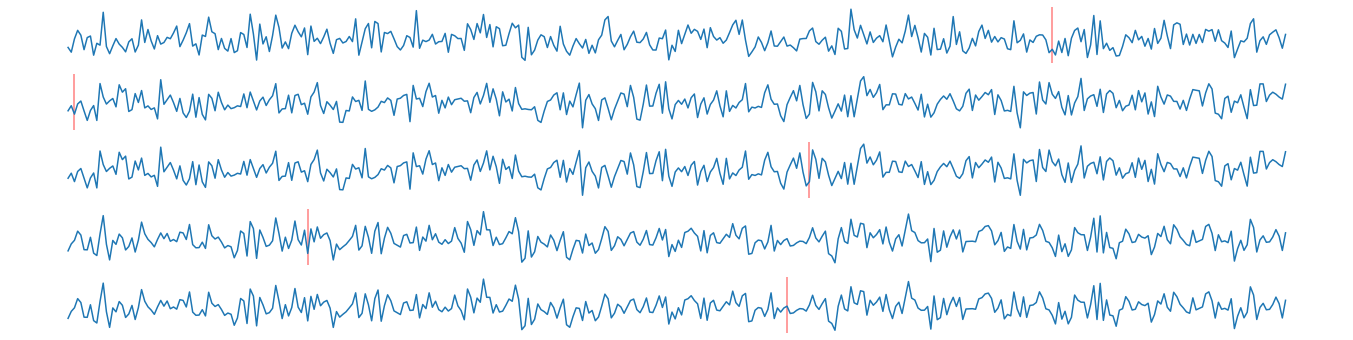

Training lstm ..
Rewards: [-0.75, -0.73, -0.745, 0.405, -0.75, -0.75, 0.585, 0.45, 0.53, -0.745]
lstm loss (epochs average): -7.66933915485879e-07
NAS epoch 29
Epoch average accuracy (10 sequences): 0.686


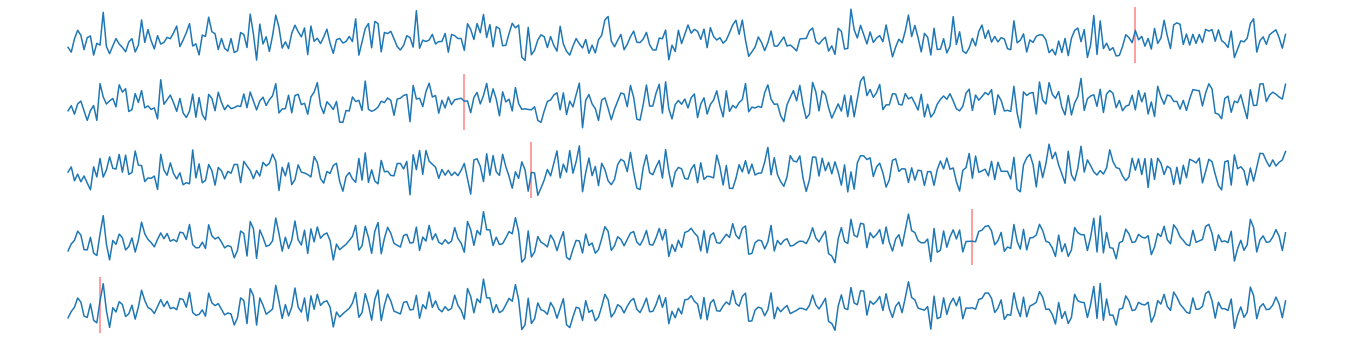

Training lstm ..
Rewards: [-0.97, 0.17, -0.965, -1.05, 0.35, 0.3, -1.065, 0.285, 0.195, 0.225]
lstm loss (epochs average): -7.158049939448574e-07
NAS epoch 30
Epoch average accuracy (10 sequences): 0.748


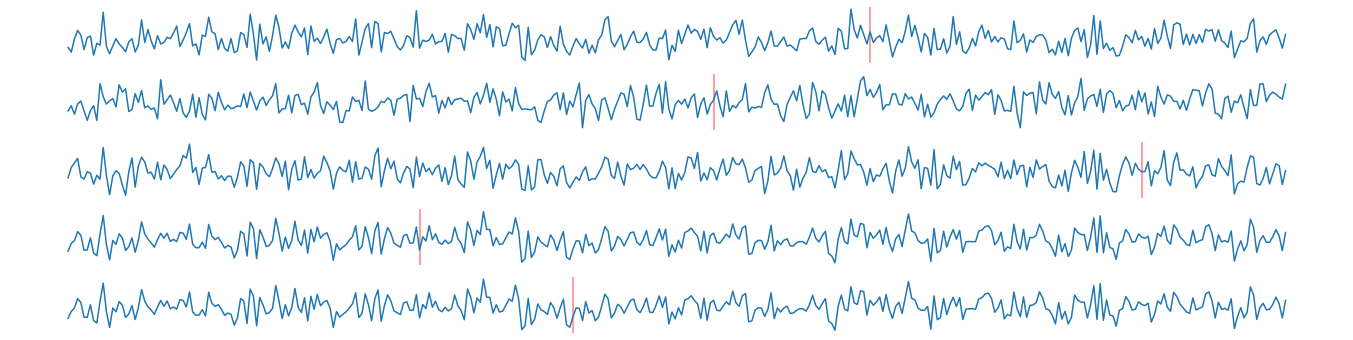

Training lstm ..
Rewards: [-0.795, 0.03, -0.12, -0.23, 0.02, 0.24, 0.07, -0.24, -1.36, -0.13]
lstm loss (epochs average): -6.007649044903474e-07
NAS epoch 31
Epoch average accuracy (10 sequences): 0.666


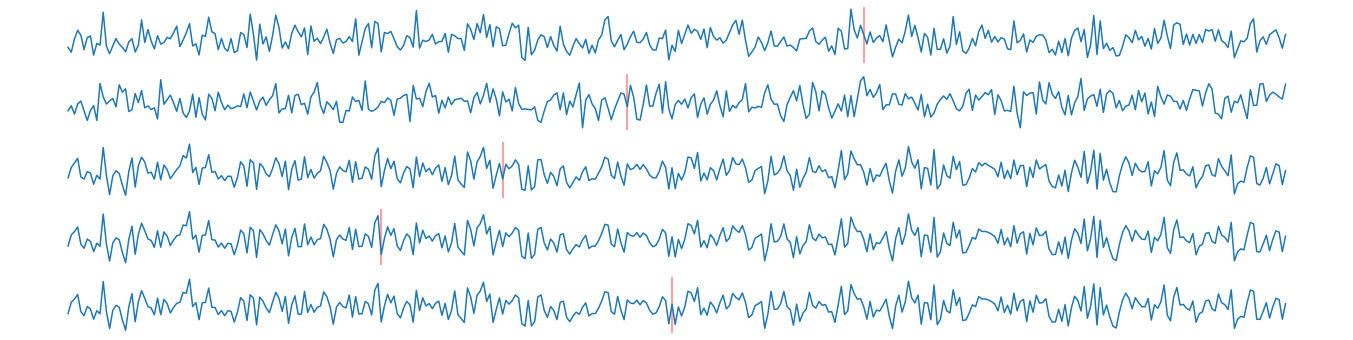

Training lstm ..
Rewards: [-1.0, 0.22, -0.995, -1.005, 0.265, 0.295, -1.0, 0.21, 0.06, 0.46]
lstm loss (epochs average): -7.030227564541747e-07
NAS epoch 32
Epoch average accuracy (10 sequences): 0.75


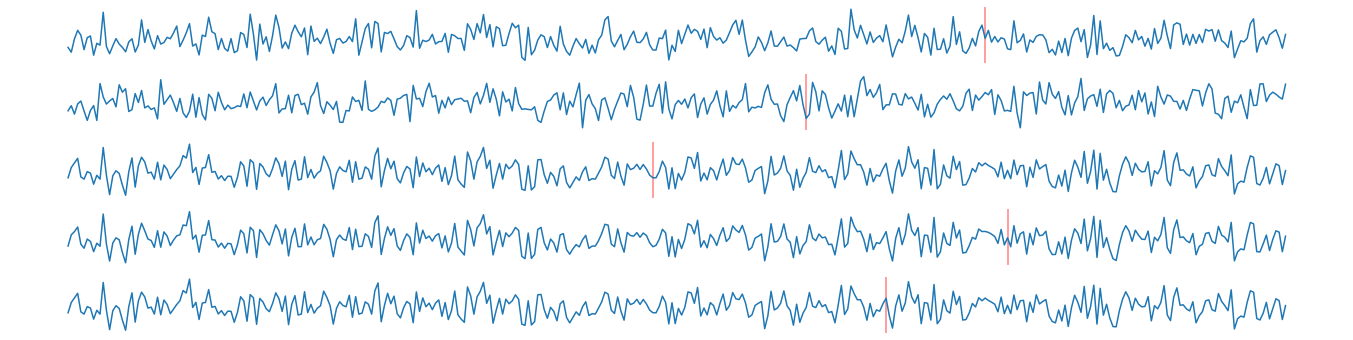

Training lstm ..
Rewards: [-0.26, -0.045, -1.025, -0.035, 0.025, 0.105, -0.025, 0.06, -0.565, -0.76]
lstm loss (epochs average): -6.391115938697567e-07
NAS epoch 33
Epoch average accuracy (10 sequences): 0.712


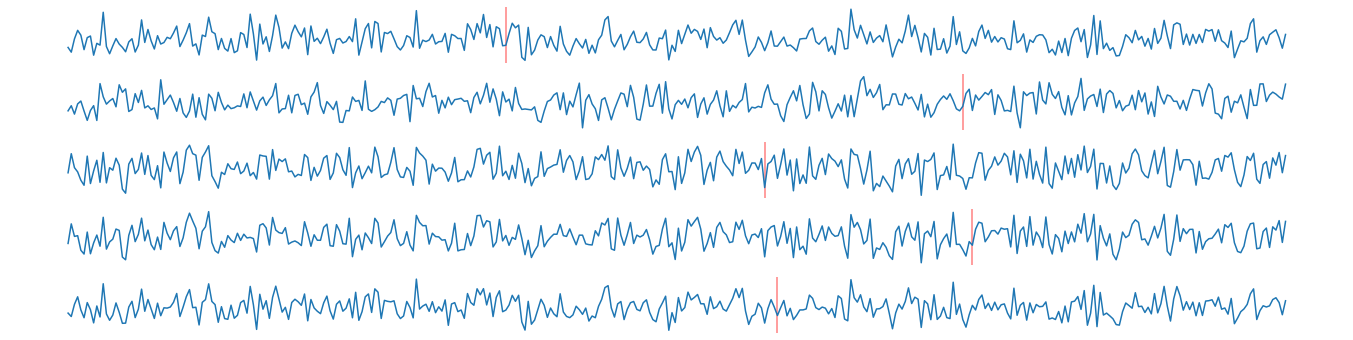

Training lstm ..
Rewards: [-1.23, -0.435, -0.44, 0.035, 0.105, 0.22, 0.265, -0.03, -1.115, 0.115]
lstm loss (epochs average): -7.030227493487473e-07
NAS epoch 34
Epoch average accuracy (10 sequences): 0.628


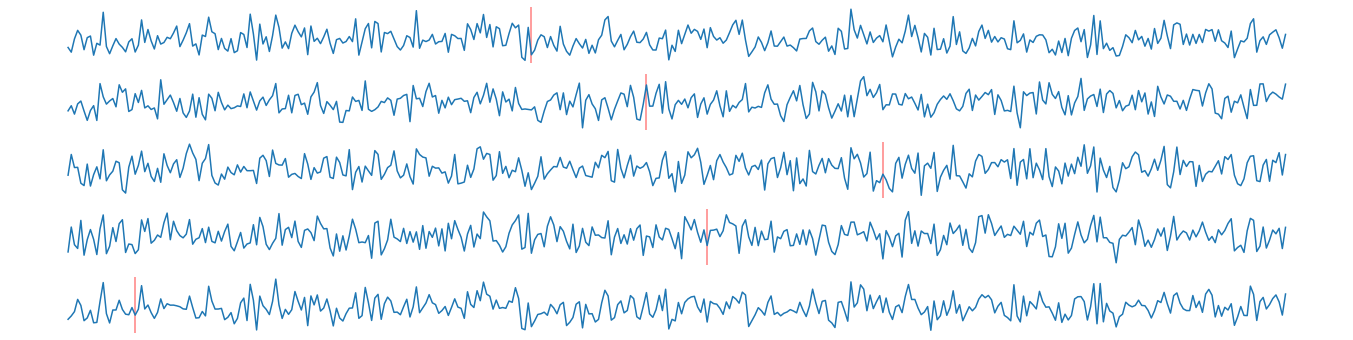

Training lstm ..
Rewards: [-0.81, -0.49, 0.27, 0.62, 0.55, -0.71, -0.81, -0.805, -0.8, 0.495]
lstm loss (epochs average): -7.285872118956149e-07
NAS epoch 35
Epoch average accuracy (10 sequences): 0.742


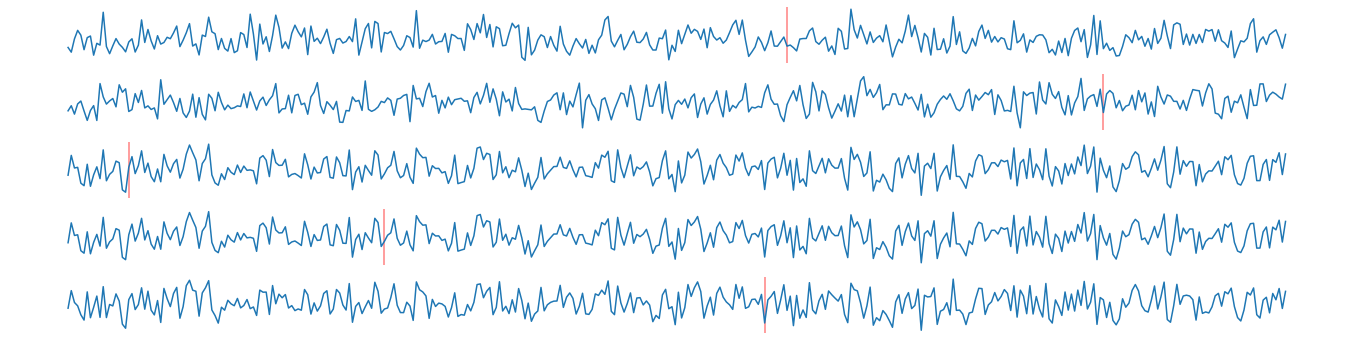

Training lstm ..
Rewards: [0.065, -0.55, -0.02, -0.08, -1.385, 0.13, -0.525, 0.095, -0.16, -0.045]
lstm loss (epochs average): -4.985070454210927e-07
NAS epoch 36
Epoch average accuracy (10 sequences): 0.634


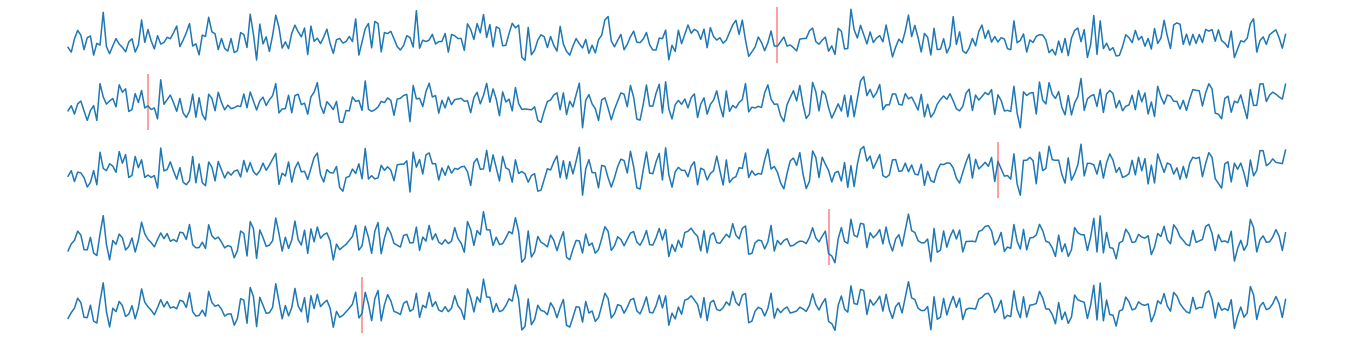

Training lstm ..
Rewards: [-0.845, 0.595, 0.505, 0.475, -0.84, -0.835, 0.585, -0.555, -0.755, -0.82]
lstm loss (epochs average): -6.135471295465322e-07
NAS epoch 37
Epoch average accuracy (10 sequences): 0.654


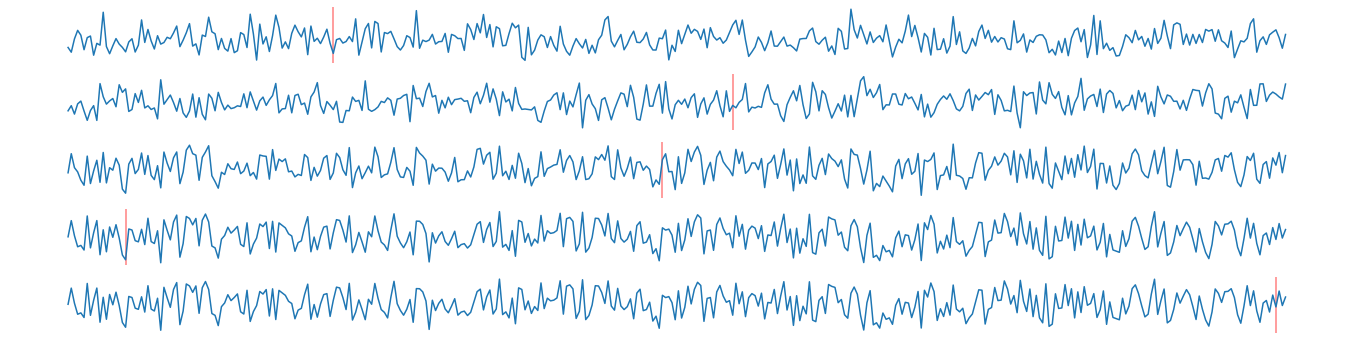

Training lstm ..
Rewards: [-0.77, -0.93, -0.87, 0.375, 0.015, 0.475, -0.94, 0.585, 0.52, -0.94]
lstm loss (epochs average): -3.834669595192963e-07
NAS epoch 38
Epoch average accuracy (10 sequences): 0.657


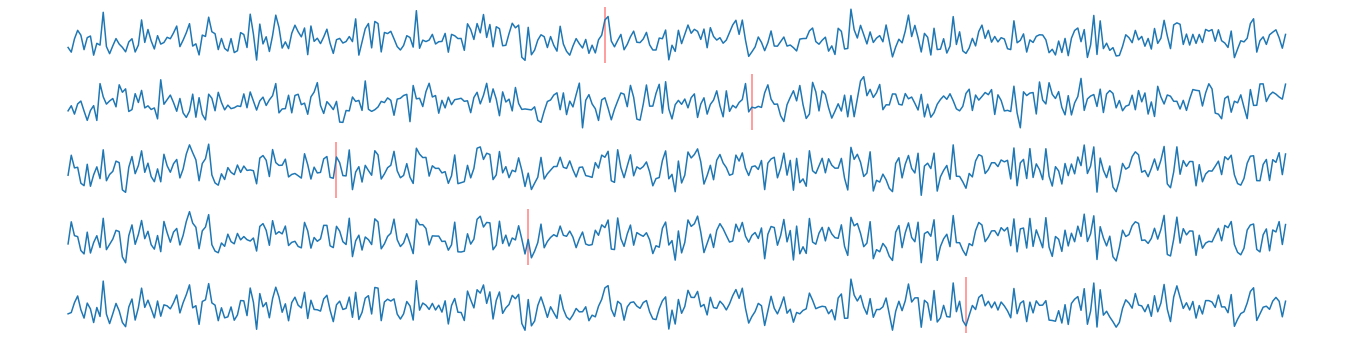

Training lstm ..
Rewards: [0.3, -0.89, 0.47, 0.465, -0.955, 0.385, -0.96, -0.835, -0.96, 0.505]
lstm loss (epochs average): -6.646760617456948e-07
NAS epoch 39
Epoch average accuracy (10 sequences): 0.66


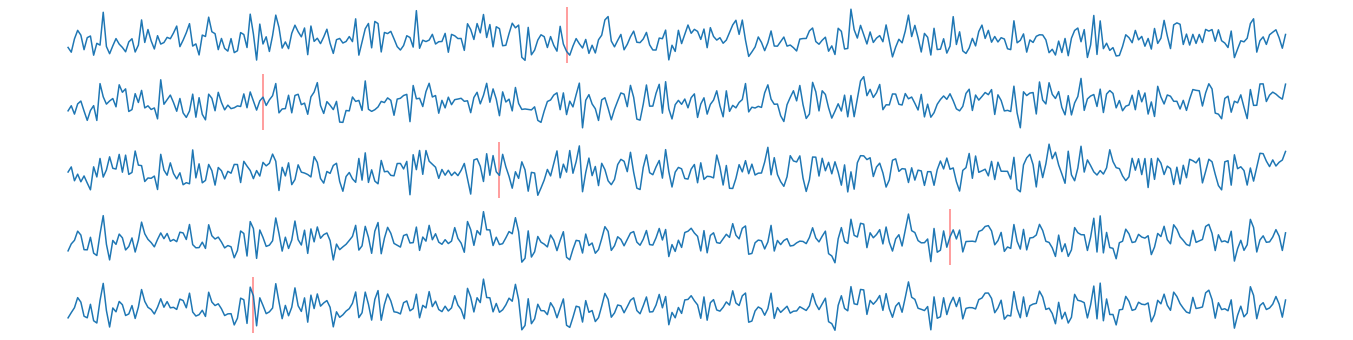

Training lstm ..
Rewards: [0.37, 0.275, 0.43, 0.435, -0.66, 0.51, -0.97, -0.97, -0.97, -0.975]
lstm loss (epochs average): -6.774582903545934e-07
NAS epoch 40
Epoch average accuracy (10 sequences): 0.712


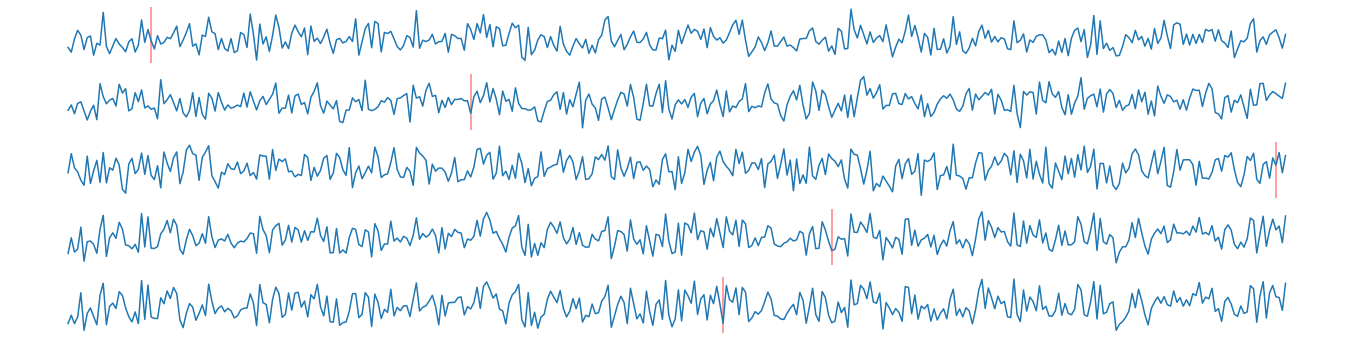

Training lstm ..
Rewards: [-1.23, 0.175, 0.155, 0.135, 0.14, 0.23, -1.235, 0.24, 0.11, -1.195]
lstm loss (epochs average): -7.797161458711344e-07
Done.


In [12]:
history_data_x = []
history_data_acc = []
history_lstm_loss = []
history_avg_acc = []
history_rewards = []

for nas_epoch in range(no_of_nas_epochs):
    sequences = []
    data_x = None
    accuracies = []
    data_acc = None
    print("NAS epoch", nas_epoch+1)
    sample_seq = 0
    while sample_seq < no_of_samples_per_epoch:
#         sequence = np.zeros((1,1,max_no_of_layers-1), dtype="int32")
        sequence = np.zeros((1,6,max_no_of_layers-1), dtype="int32")
        probs, selects = [], []
        layer = 0
        while layer < max_no_of_layers-1:
            distribution = model.predict(sequence)
            prob = distribution[0]#[0]
            selected = np.random.choice(search_space, size=1, p=prob)[0]
#             max_args = np.argsort(prob)[-2:]
#             selected_idx = np.random.choice(max_args)
#             selected = search_space[selected_idx]
            if not selected == 0:
                sequence[0][0][layer] = selected
                probs.append(prob); selects.append(selected)
                layer += 1
        
        sequence = sequence[0][0].tolist()
        sequence = sequence + [int(search_space[-1])]
        if sequence not in sequences:
            sequences.append(sequence)
            sequence_acc = performance_estimate(sequence)
            accuracies.append(sequence_acc)
            sample_seq += 1

        data_acc = np.vstack(accuracies)
    
    avg_acc = round(np.average(accuracies),3)
    print(f"Epoch average accuracy ({no_of_samples_per_epoch} sequences):", avg_acc)
    baseline = avg_acc + 0.05
    plot_distribution(search_space, probs, selects)
    print("Training lstm ..")
    rewards_ = (rew_coef * (data_acc - baseline)).tolist()
    print("Rewards:", [round(i[0], 4) for i in rewards_])
#     data_x = np.array(sequences)[:, :-1].reshape(len(sequences), 1, max_no_of_layers-1)
    sequences_expanded = [expand_token(i)[:-1] for i in sequences]
    data_x = np.array(sequences_expanded).reshape(len(sequences), 6, max_no_of_layers-1)
    data_y = to_categorical(np.array(sequences)[:, -1], len(search_space)+1).reshape(len(sequences), 1, len(search_space)+1)
    history = model.fit({'main_input': data_x},
                        {'main_output': data_y},
                        epochs=rnn_train_epochs,
                        batch_size=len(data_x),
                        verbose=0)
    lstm_loss_avg = np.average(list(history.history.values())[0])
    print("lstm loss (epochs average):", lstm_loss_avg)
    
    history_avg_acc.append(avg_acc)
    history_lstm_loss.append(lstm_loss_avg)
    history_data_x.append(data_x)
    history_data_acc.append(data_acc)   
    history_rewards.append(rewards_) 
print("Done.")

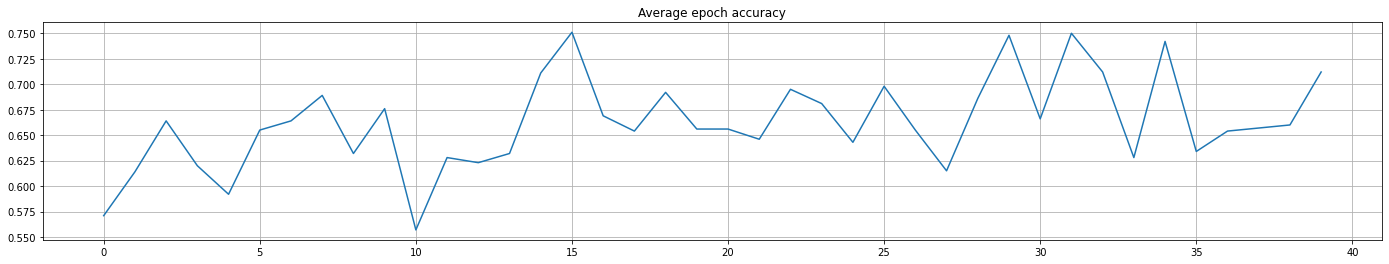

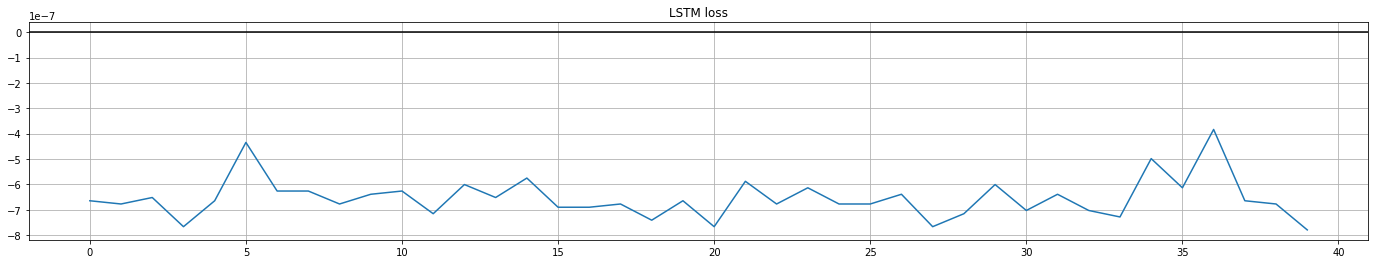

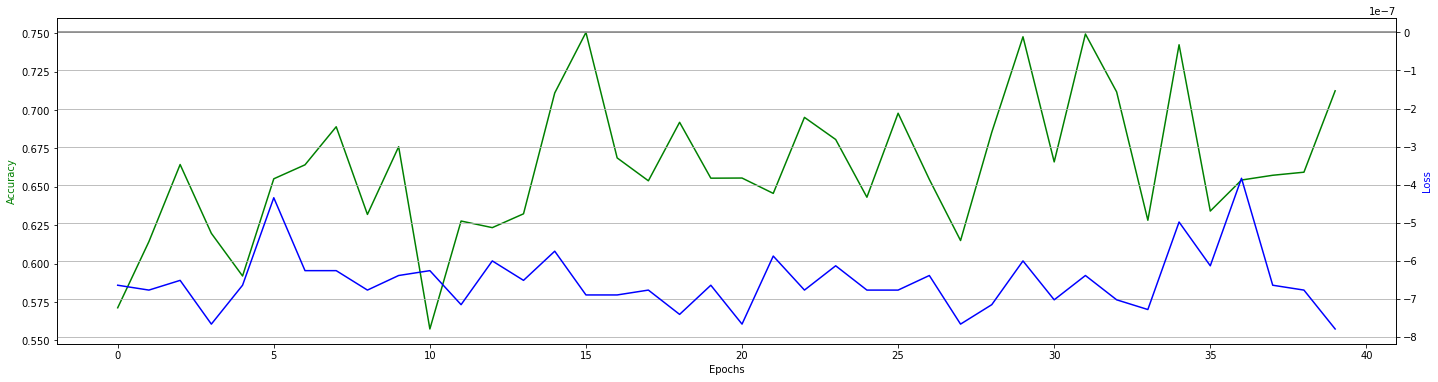

In [13]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_avg_acc)), history_avg_acc)
plt.title("Average epoch accuracy")
plt.grid()
plt.show()
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_lstm_loss)), history_lstm_loss)
plt.title("LSTM loss")
plt.axhline(y=0, c="k")
plt.grid()
plt.show()

fig, ax1 = plt.subplots(figsize=(24, 6))
ax2 = ax1.twinx()

all_acc_avg = [[np.average(i)] for i in history_data_acc]
all_acc_avg = [item for sublist in all_acc_avg for item in sublist]

ax1.plot(np.arange(0,len(all_acc_avg)), all_acc_avg, c="g")
ax2.plot(np.arange(0,len(history_lstm_loss)), history_lstm_loss, c="b")
ax2.axhline(y=0, c="gray")

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy", color='g')
ax2.set_ylabel("Loss", color='b')
plt.grid()
plt.show()

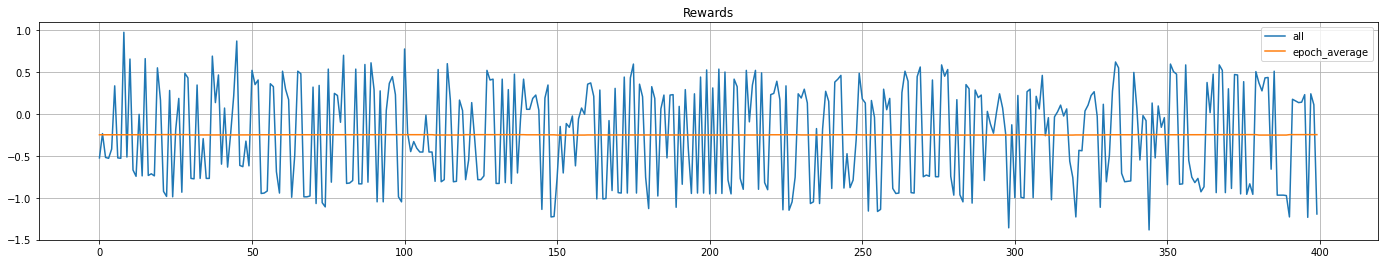

In [14]:
fig = plt.figure(figsize=(24, 4))
all_rew = np.array(history_rewards)
all_rew = all_rew.reshape(all_rew.shape[0]*all_rew.shape[1],1)

rewards_avg = [[np.average(i)]*no_of_samples_per_epoch for i in history_rewards]
rewards_avg = [item for sublist in rewards_avg for item in sublist]

plt.plot(np.arange(0,len(all_rew)), all_rew, label="all")
plt.plot(np.arange(0,len(rewards_avg)), rewards_avg, label="epoch_average")
plt.title("Rewards")
plt.legend()
plt.grid()
plt.show()

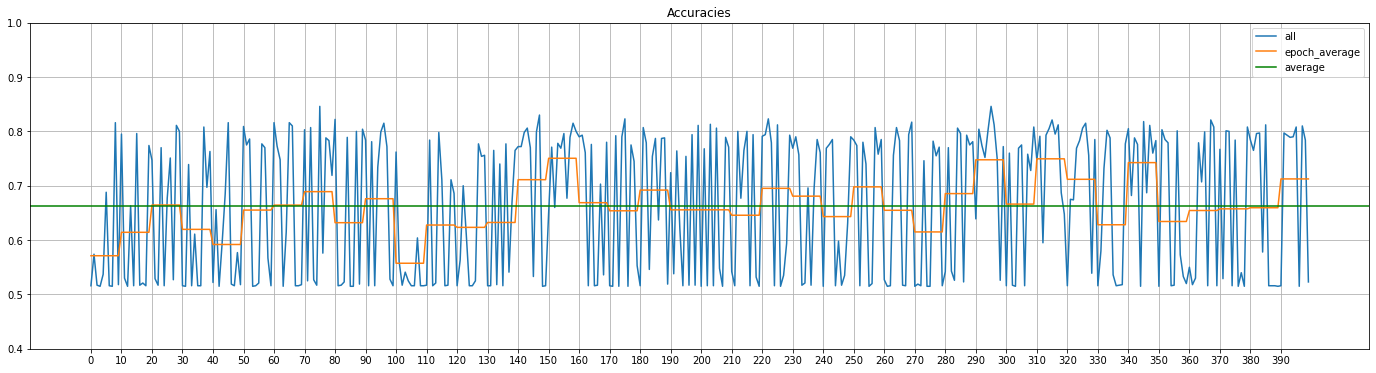

Total accuracy average: 0.66222245
Best accuracy: 0.846


In [15]:
fig = plt.figure(figsize=(24, 6))
all_acc = np.array(history_data_acc)
all_acc = all_acc.reshape(all_acc.shape[0]*all_acc.shape[1],1)
plt.plot(np.arange(0,len(all_acc)), all_acc, label="all")

all_acc_avg = [[np.average(i)]*no_of_samples_per_epoch for i in history_data_acc]
all_acc_avg = [item for sublist in all_acc_avg for item in sublist]
plt.plot(np.arange(0,len(all_acc_avg)), all_acc_avg, label="epoch_average")

# plt.axhline(y=baseline, c="r", label="baseline")
plt.axhline(y=np.average(all_acc), c="g", label="average")
plt.title("Accuracies")
plt.xticks(range(0,len(all_acc), no_of_samples_per_epoch))
plt.ylim([0.4,1])
plt.grid()
plt.legend()
plt.show()
print("Total accuracy average:", np.average(all_acc))
print("Best accuracy:", np.max(all_acc))

In [16]:
# random_acc = []
# for i in range(len(all_acc)):
#     random_acc.append(performance_estimate(np.random.randint(low=1, high=len(search_space), size=max_no_of_layers)))

# fig = plt.figure(figsize=(24, 6))
# plt.plot(np.arange(0,len(random_acc)), random_acc)
# plt.ylim([0,1])
# plt.grid()
# plt.xticks(range(0,len(all_acc), no_of_samples_per_epoch))
# plt.axhline(y=baseline, c="r")
# plt.axhline(y=np.average(random_acc), c="g")
# plt.title("Random")
# plt.show()
# print(np.average(random_acc))

In [22]:
# data_y = to_categorical(np.array(sequences)[:, -1], len(search_space)+1).reshape(len(sequences), 1, len(search_space)+1)
# data_y.shape

In [23]:
model = None
main_input = keras.engine.input_layer.Input(shape=(6, max_no_of_layers-1), batch_shape=None, name="main_input")
x = keras.layers.LSTM(rnn_dim, return_sequences=False)(main_input)
main_output = keras.layers.Dense(len(search_space), activation="softmax", name="main_output")(x)
model = keras.models.Model(inputs=[main_input], outputs=[main_output])

sequence = np.zeros((1,6,max_no_of_layers-1), dtype="int32")
sequence.shape

In [24]:
sequence = np.zeros((1,6,max_no_of_layers-1), dtype="int32")
sequence.shape

(1, 6, 5)

In [25]:
distribution = model.predict(sequence)
# prob = distribution[0][0]
# selected = np.random.choice(search_space, size=1, p=prob)[0]

In [26]:
distribution.shape

(1, 382)

In [27]:
prob = distribution[0]
selected = np.random.choice(search_space, size=1, p=prob)[0]

In [28]:
selected

341.0

In [29]:
distribution.shape

(1, 382)

In [30]:
distribution = model.predict(sequence)
select_ = []
for prob in distribution[0]:
    select_.append(np.random.choice(search_space, size=1, p=prob)[0])

TypeError: object of type 'numpy.float32' has no len()

In [ ]:
select_